In [1]:
# add folders to Python's search space
import os, sys
from pathlib import Path
script_dir = Path(os.path.dirname(os.path.abspath('')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
print(module_dir)

# import the rest of the modules
%matplotlib nbagg
%matplotlib inline
import numpy as np
import tensorflow as tf 
import matplotlib
import matplotlib.pyplot as plt
import arch
import pandas as pd
from scipy.signal import savgol_filter
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.transforms as mtrans
DTYPE = 'float32'

/Users/pman0581/Documents/GitHub/var-al


In [2]:
# load learned solutions
net_p = arch.LSTMForgetNet(50, 3, DTYPE, name="Grad-Shafranov")
net_p.load_weights('../data/Grad-Shafranov/{}'.format(net_p.name)).expect_partial()

net_al = arch.LSTMForgetNet(50, 3, DTYPE, name='Grad-Shafranov-al')
net_al.load_weights('../data/Grad-Shafranov-al/{}'.format(net_al.name)).expect_partial()


R, a, b, c0 = 1., 1.2, -1., 1.1
rb, zb = [0.9*R, 1.1*R], [-0.1*R, 0.1*R]

# define the true solution
def true(r, z):
    r2, z2, R2 = r*r, z*z, R*R
    zeta = (r2 - R2) / (2.*R)
    A = 0.5 * (b + c0) * R2 * z2
    B = c0 * zeta * R * z2
    C = 0.5 * (a - c0) * R2 * zeta * zeta
    return A + B + C

2023-12-20 11:26:52.176381: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-20 11:26:52.176402: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-20 11:26:52.176409: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-20 11:26:52.176437: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-20 11:26:52.176449: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


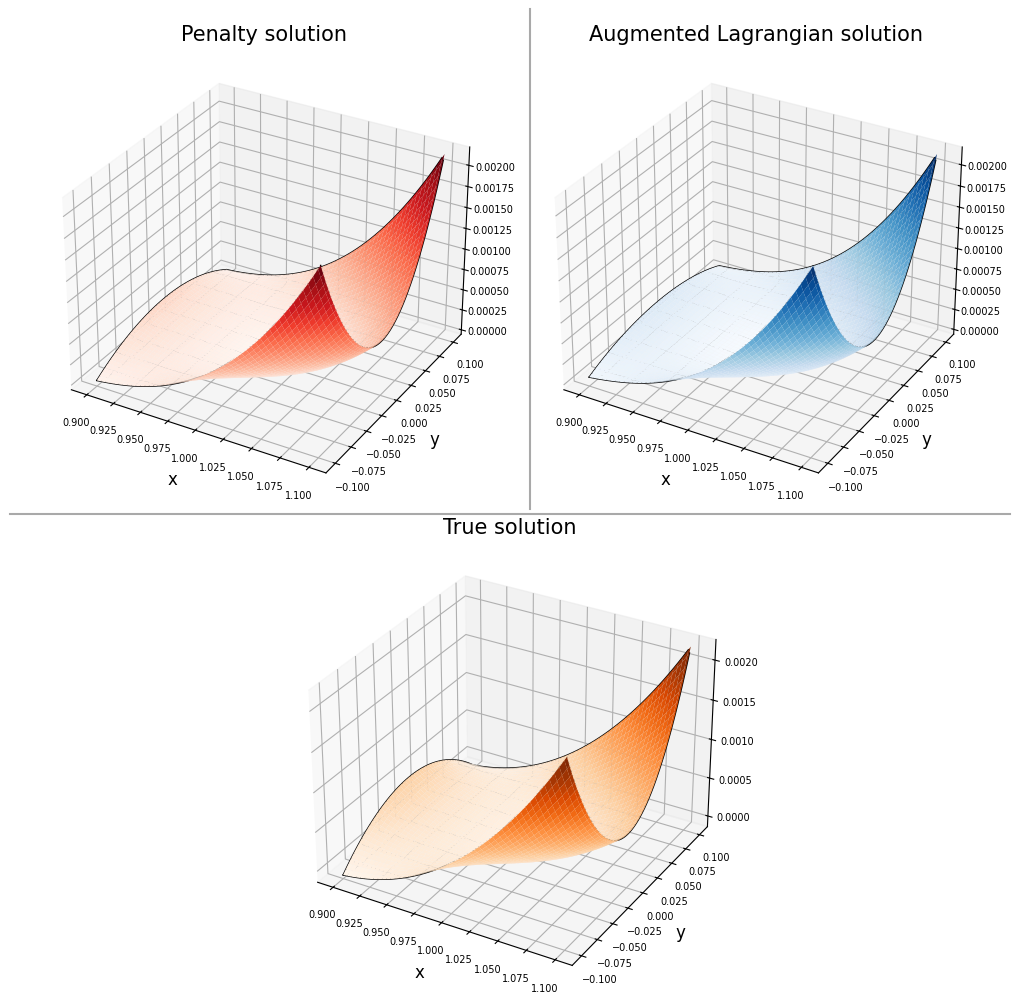

In [3]:
# set up plotting parameters
scale = 0
xlabel_size = ylabel_size = 12 + scale
tick_size = 7 + scale
legend_size = 15 + scale
title_size = 15 + scale
cbar_tick_size = 10 + scale
line_color = "darkgrey"

# plot solutions
def plot_solutions(filename, resolution=100):
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(2, 4, figure=fig)
    ax_p = fig.add_subplot(gs[0,:-2], projection='3d')
    ax_al = fig.add_subplot(gs[0,2:], projection='3d')
    ax_t = fig.add_subplot(gs[1,1:-1], projection='3d')
    # plotting params  
    ax_p.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_p.tick_params(axis='both', which='minor', labelsize=tick_size)
    ax_p.set_title('Penalty solution', fontsize=title_size)
    ax_p.set_xlabel('x', fontsize=xlabel_size)
    ax_p.set_ylabel('y', fontsize=ylabel_size)
    
    ax_al.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_al.tick_params(axis='both', which='minor', labelsize=tick_size)
    ax_al.set_title('Augmented Lagrangian solution', fontsize=title_size)
    ax_al.set_xlabel('x', fontsize=xlabel_size)
    ax_al.set_ylabel('y', fontsize=ylabel_size)

    ax_t.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_t.tick_params(axis='both', which='minor', labelsize=tick_size)
    ax_t.set_title('True solution', fontsize=title_size)
    ax_t.set_xlabel('x', fontsize=xlabel_size)
    ax_t.set_ylabel('y', fontsize=ylabel_size)
    
    
#     div_1 = make_axes_locatable(ax_p)
#     cax_1 = div_1.append_axes('right', '5%', '5%')
#     div_2 = make_axes_locatable(ax_al)
#     cax_2 = div_2.append_axes('right', '5%', '5%')
#     div_3 = make_axes_locatable(ax_t)
#     cax_3 = div_3.append_axes('right', '5%', '5%')
    

    r = np.linspace(rb[0], rb[1], num=resolution, endpoint=True).astype(DTYPE)
    z = np.linspace(zb[0], zb[1], num=resolution, endpoint=True).astype(DTYPE)
    r, z = np.meshgrid(r, z)
    z_p = net_p(r.reshape(-1, 1), z.reshape(-1, 1)).numpy()
    z_al = net_al(r.reshape(-1, 1), z.reshape(-1, 1)).numpy()
    z_t = true(r, z)
    grid = (resolution, resolution)
    z_p = z_p.reshape(grid)
    z_al = z_al.reshape(grid)
    z_t = z_t.reshape(grid)
    
    im = ax_p.plot_surface(r, z, z_p, cmap='Reds')
  
    
    im = ax_al.plot_surface(r, z, z_al, cmap='Blues')
    
    im = ax_t.plot_surface(r, z, z_t, cmap='Oranges')
#     ax_t.contour(r, z, z_t, 100, colors='black', linewidth=0.1)
#     cbar_1m = fig.colorbar(im, cax=cax_3, ax=ax_t)
#     cbar_1m.ax.tick_params(labelsize=cbar_tick_size)


    r_d = np.linspace(rb[0], rb[1], num=resolution, endpoint=False).astype(DTYPE)
    z_d = np.ones_like(r_d) * zb[0]
    
    z_r = np.linspace(zb[0], zb[1], num=resolution, endpoint=False).astype(DTYPE)
    r_r = np.ones_like(z_r) * rb[1]
    
    r_u = np.linspace(rb[0], rb[1], num=resolution, endpoint=False).astype(DTYPE)
    z_u = np.ones_like(r_u) * zb[1]
    
    z_l = np.linspace(zb[0], zb[1], num=resolution, endpoint=False).astype(DTYPE)
    r_l = np.ones_like(z_l) * rb[0]
    
    
    bdry = list(zip([r_d, r_r, r_u, r_l], [z_d, z_r, z_u, z_l]))
    lw = 1.0
    for r, z in bdry:
        ax_p.plot(r, z, net_p(r.reshape(-1, 1), z.reshape(-1, 1)).numpy().flatten(), c='black', lw=lw)
        ax_al.plot(r, z, net_al(r.reshape(-1, 1), z.reshape(-1, 1)).numpy().flatten(), c='black', lw=lw)
        ax_t.plot(r, z, true(r, z), c='black', lw=lw)
  
    # plot and save
    fig.subplots_adjust(wspace=0., hspace=0.2)
#     Get the bounding boxes of the axes including text decorations
    l = 0.475
    line = plt.Line2D([l+.045,l+.045],[0.5,1], transform=fig.transFigure, color=line_color)
    fig.add_artist(line)
    l = 0.45
    line = plt.Line2D([0.0,1],[l+.045,l+.045], transform=fig.transFigure, color=line_color)
    fig.add_artist(line)
    fig.tight_layout()
    plt.savefig('{}.png'.format(filename), dpi=300)
    plt.show()

plot_solutions(filename='../plots/Grad-Shafranov-surface')

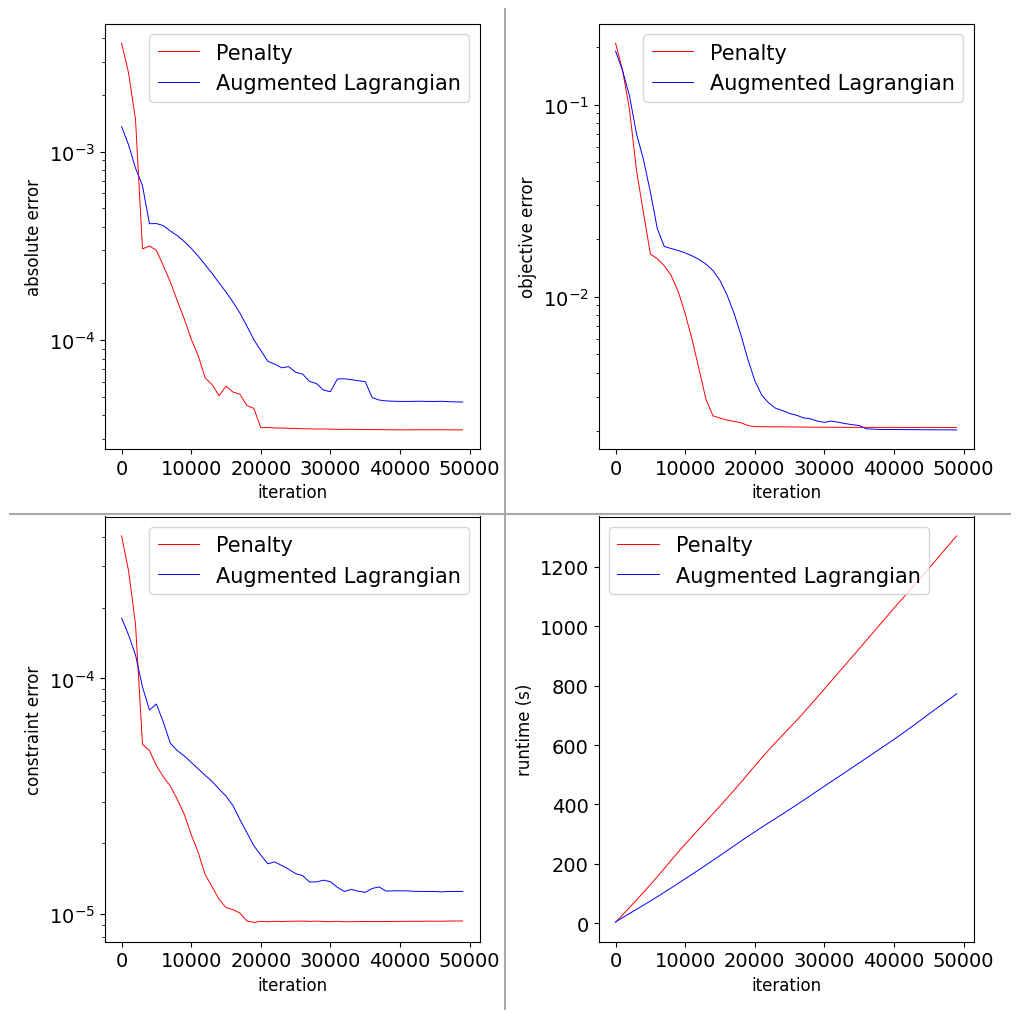

In [4]:
def smooth(y, k):
    y_smooth = savgol_filter(y, 5, k)
    return y_smooth

tick_size = 14 + scale
def plot_errors(filename, last, interval, k):
    fig = plt.figure(figsize=(10, 10))
    ax_l = fig.add_subplot(221)
    ax_o = fig.add_subplot(222)
    ax_c = fig.add_subplot(223)
    ax_m = fig.add_subplot(224)
    # plotting params  
    ax_l.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_l.tick_params(axis='both', which='minor', labelsize=tick_size)
    #ax_l.set_title('Penalty solution', fontsize=title_size)
    ax_l.set_xlabel('iteration', fontsize=xlabel_size)
    ax_l.set_ylabel(r'absolute error', fontsize=ylabel_size)
    
    ax_o.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_o.tick_params(axis='both', which='minor', labelsize=tick_size)
    #ax_o.set_title('Augmented Lagrangian solution', fontsize=title_size)
    ax_o.set_xlabel('iteration', fontsize=xlabel_size)
    ax_o.set_ylabel('objective error', fontsize=ylabel_size)

    ax_c.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_c.tick_params(axis='both', which='minor', labelsize=tick_size)
    #ax_c.set_title('True solution', fontsize=title_size)
    ax_c.set_xlabel('iteration', fontsize=xlabel_size)
    ax_c.set_ylabel('constraint error', fontsize=ylabel_size)

    ax_m.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_m.tick_params(axis='both', which='minor', labelsize=tick_size)
    #ax_c.set_title('True solution', fontsize=title_size)
    ax_m.set_xlabel('iteration', fontsize=xlabel_size)
    ax_m.set_ylabel('runtime (s)', fontsize=ylabel_size)
    
    df_p = pd.read_csv('../data/Grad-Shafranov/train_log.csv')
    df_al = pd.read_csv('../data/Grad-Shafranov-al/train_log.csv')

    x = df_p['iteration'].to_numpy()[0:last:interval]
    ax_l.semilogy(x, smooth(df_p['L2-error'].to_numpy()[0:last:interval], k), linewidth=0.7, label='Penalty', c='red')
    ax_l.semilogy(x, smooth(df_al['L2-error'].to_numpy()[0:last:interval], k), linewidth=0.7, label='Augmented Lagrangian', c='blue')
    ax_l.legend(fontsize=legend_size)
    ax_o.semilogy(x, smooth(np.abs(df_p['objective-error'].to_numpy()[0:last:interval]), k), linewidth=0.7, label='Penalty', c='red')
    ax_o.semilogy(x, smooth(np.abs(df_al['objective-error'].to_numpy()[0:last:interval]), k), linewidth=0.7, label='Augmented Lagrangian', c='blue')
    ax_o.legend(fontsize=legend_size)
    ax_c.semilogy(x, smooth(np.abs(df_p['constraint-error'].to_numpy()[0:last:interval]), k), linewidth=0.7, label='Penalty', c='red')
    ax_c.semilogy(x, smooth(np.abs(df_al['constraint-error'].to_numpy()[0:last:interval]), k), linewidth=0.7, label='Augmented Lagrangian', c='blue')
    ax_c.legend(fontsize=legend_size)
    ax_m.plot(x, smooth(np.abs(df_p['runtime'].to_numpy()[0:last:interval]), k), linewidth=0.7, label='Penalty', c='red')
    ax_m.plot(x, smooth(np.abs(df_al['runtime'].to_numpy()[0:last:interval]), k), linewidth=0.7, label='Augmented Lagrangian', c='blue')
    ax_m.legend(fontsize=legend_size)
    l = 0.45
    line = plt.Line2D([l+.045,l+.045],[0.,1], transform=fig.transFigure, color=line_color)
    fig.add_artist(line)
    l = 0.45
    line = plt.Line2D([0.0,1],[l+.045,l+.045], transform=fig.transFigure, color=line_color)
    fig.add_artist(line)
    fig.tight_layout()
    plt.savefig('{}.png'.format(filename), dpi=300)
    plt.show()
    

plot_errors('../plots/Grad-Shafranov-error', last=500, interval=10, k=1)

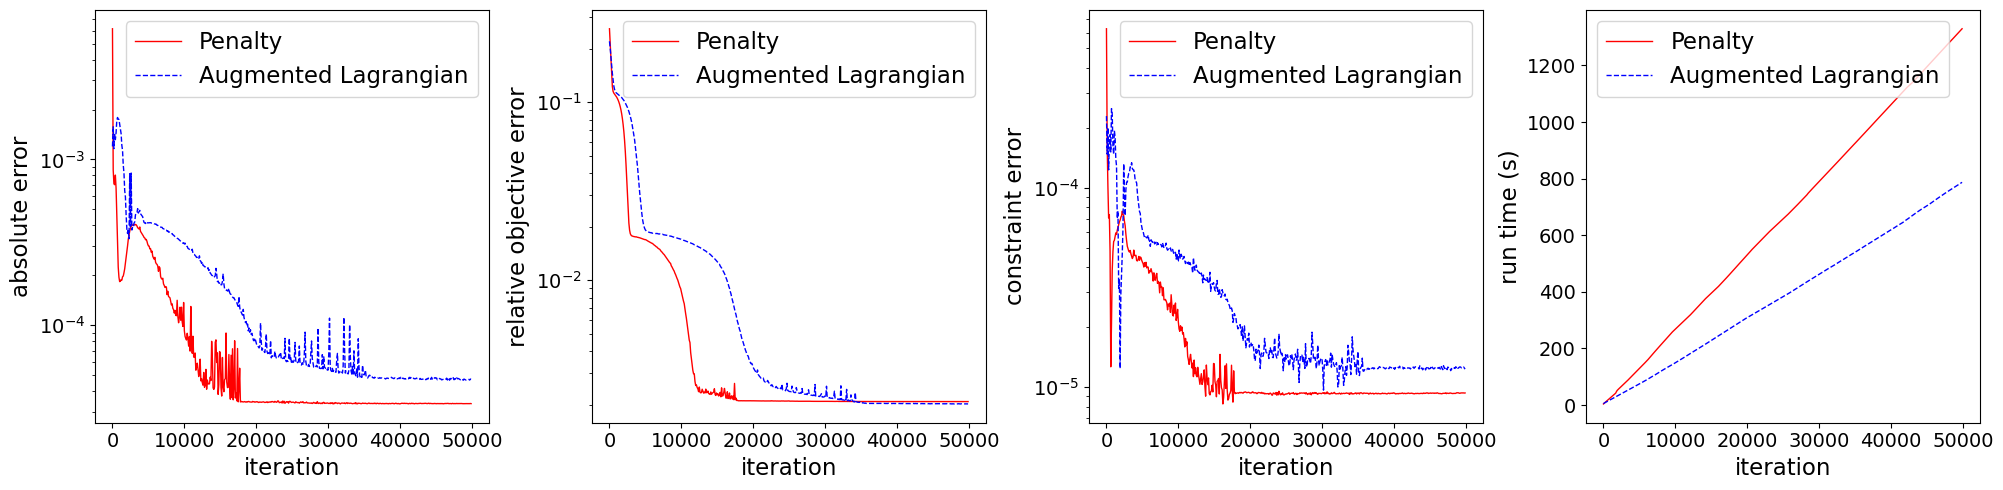

In [25]:
scale = 0
xlabel_size = ylabel_size = 16.5 + scale
tick_size = 7 + scale
legend_size = 16.5 + scale
title_size = 15 + scale
cbar_tick_size = 10 + scale
line_color = "darkgrey"


def smooth(y, k):
    if k == -1:
        return y
    else:
        return savgol_filter(y, 1, k)


tick_size = 14 + scale
def plot_errors(filename, last, interval, k):
    fig = plt.figure(figsize=(20, 5))
    ax_l = fig.add_subplot(141)
    ax_o = fig.add_subplot(142)
    ax_c = fig.add_subplot(143)
    ax_m = fig.add_subplot(144)
    # plotting params  
    ax_l.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_l.tick_params(axis='both', which='minor', labelsize=tick_size)
    #ax_l.set_title('Penalty solution', fontsize=title_size)
    ax_l.set_xlabel('iteration', fontsize=xlabel_size)
    ax_l.set_ylabel(r'absolute error', fontsize=ylabel_size)
    
    ax_o.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_o.tick_params(axis='both', which='minor', labelsize=tick_size)
    #ax_o.set_title('Augmented Lagrangian solution', fontsize=title_size)
    ax_o.set_xlabel('iteration', fontsize=xlabel_size)
    ax_o.set_ylabel('relative objective error', fontsize=ylabel_size)

    ax_c.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_c.tick_params(axis='both', which='minor', labelsize=tick_size)
    #ax_c.set_title('True solution', fontsize=title_size)
    ax_c.set_xlabel('iteration', fontsize=xlabel_size)
    ax_c.set_ylabel('constraint error', fontsize=ylabel_size)

    ax_m.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_m.tick_params(axis='both', which='minor', labelsize=tick_size)
    #ax_c.set_title('True solution', fontsize=title_size)
    ax_m.set_xlabel('iteration', fontsize=xlabel_size)
    ax_m.set_ylabel('run time (s)', fontsize=ylabel_size)
    
    df_p = pd.read_csv('../data/Grad-Shafranov/train_log.csv')
    df_al = pd.read_csv('../data/Grad-Shafranov-al/train_log.csv')

    x = df_p['iteration'].to_numpy()[0:last:interval]
    ax_l.semilogy(x, smooth(df_p['L2-error'].to_numpy()[0:last:interval], k), linewidth=1, label='Penalty', c='red')
    ax_l.semilogy(x, smooth(df_al['L2-error'].to_numpy()[0:last:interval], k), linewidth=1, label='Augmented Lagrangian', c='blue', linestyle='--')
    ax_l.legend(fontsize=legend_size)
    ax_o.semilogy(x, smooth(np.abs(df_p['objective-error'].to_numpy()[0:last:interval]), k), linewidth=1, label='Penalty', c='red')
    ax_o.semilogy(x, smooth(np.abs(df_al['objective-error'].to_numpy()[0:last:interval]), k), linewidth=1, label='Augmented Lagrangian', c='blue', linestyle='--')
    ax_o.legend(fontsize=legend_size)
    ax_c.semilogy(x, smooth(np.abs(df_p['constraint-error'].to_numpy()[0:last:interval]), k), linewidth=1, label='Penalty', c='red')
    ax_c.semilogy(x, smooth(np.abs(df_al['constraint-error'].to_numpy()[0:last:interval]), k), linewidth=1, label='Augmented Lagrangian', c='blue', linestyle='--')
    ax_c.legend(fontsize=legend_size)
    ax_m.plot(x, smooth(np.abs(df_p['runtime'].to_numpy()[0:last:interval]), k), linewidth=1, label='Penalty', c='red')
    ax_m.plot(x, smooth(np.abs(df_al['runtime'].to_numpy()[0:last:interval]), k), linewidth=1, label='Augmented Lagrangian', c='blue', linestyle='--')
    ax_m.legend(fontsize=legend_size)
    # l = 0.4525
    # line = plt.Line2D([l+.045,l+.045],[0.05,0.98], transform=fig.transFigure, color=line_color)
    # fig.add_artist(line)
    # l = 0.205
    # line = plt.Line2D([l+.045,l+.045],[0.05,0.98], transform=fig.transFigure, color=line_color)
    # fig.add_artist(line)
    # l = 0.705
    # line = plt.Line2D([l+.045,l+.045],[0.05,0.98], transform=fig.transFigure, color=line_color)
    # fig.add_artist(line)
    fig.tight_layout()
    plt.savefig('{}.png'.format(filename), dpi=300)
    plt.show()
    

plot_errors('../plots/Grad-Shafranov-error', last=500, interval=1, k=-1)

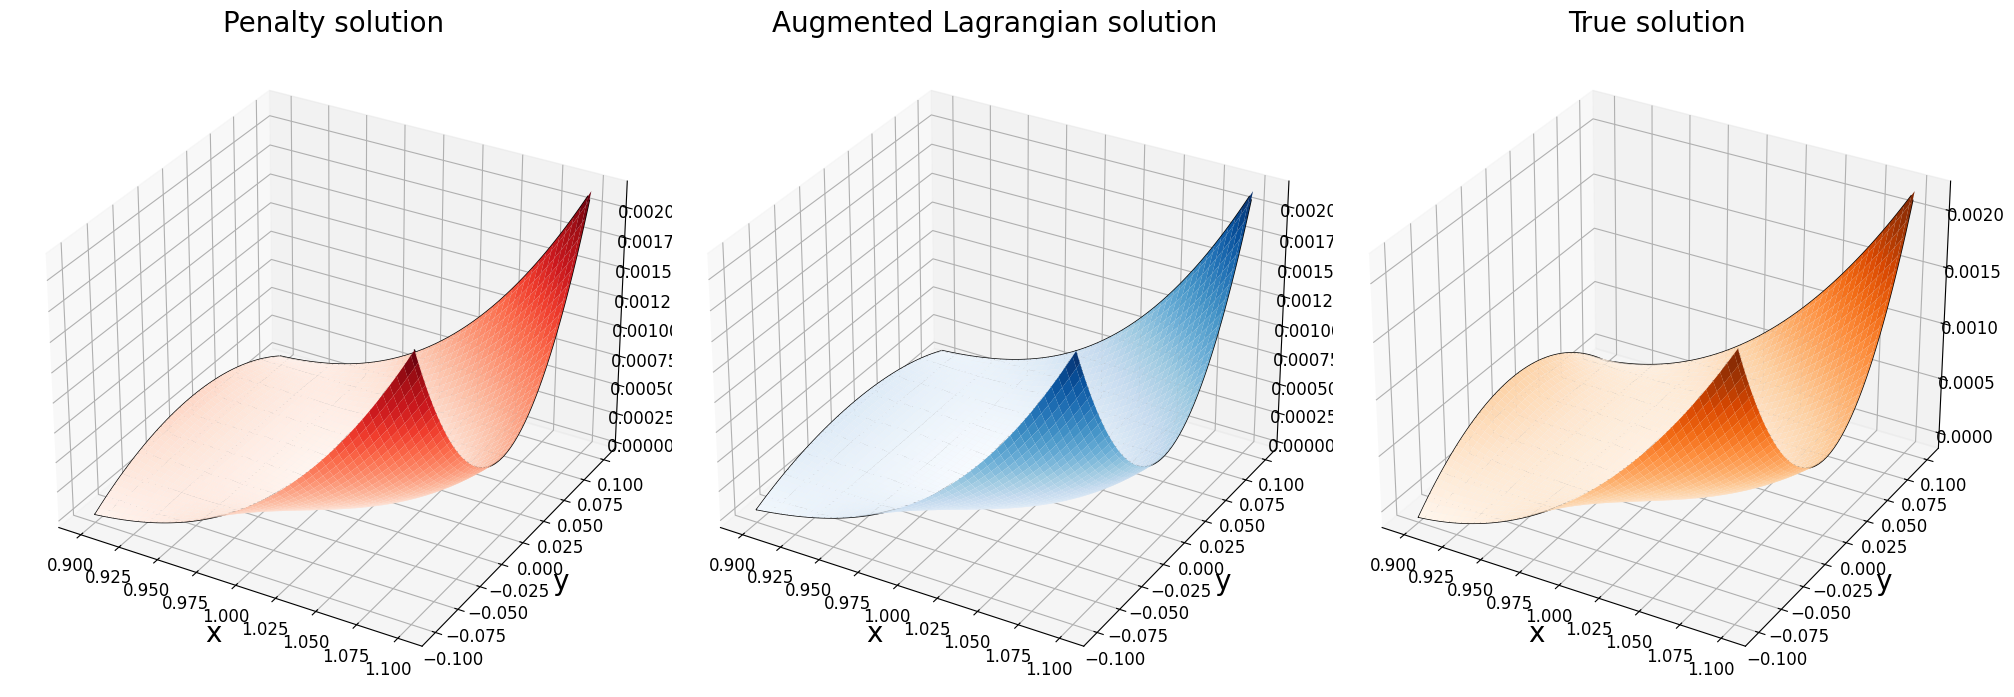

In [26]:
# set up plotting parameters
scale = 5
xlabel_size = ylabel_size = 15 + scale
tick_size = 7 + scale
legend_size = 15 + scale
title_size = 15 + scale
cbar_tick_size = 10 + scale
line_color = "darkgrey"

# plot solutions
def plot_solutions(filename, resolution=100):
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(1, 3, figure=fig)
    ax_p = fig.add_subplot(gs[0,:1], projection='3d')
    ax_al = fig.add_subplot(gs[0,1:2], projection='3d')
    ax_t = fig.add_subplot(gs[0,2:], projection='3d')
    # plotting params  
    ax_p.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_p.tick_params(axis='both', which='minor', labelsize=tick_size)
    ax_p.set_title('Penalty solution', fontsize=title_size)
    ax_p.set_xlabel('x', fontsize=xlabel_size)
    ax_p.set_ylabel('y', fontsize=ylabel_size)
    
    ax_al.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_al.tick_params(axis='both', which='minor', labelsize=tick_size)
    ax_al.set_title('Augmented Lagrangian solution', fontsize=title_size)
    ax_al.set_xlabel('x', fontsize=xlabel_size)
    ax_al.set_ylabel('y', fontsize=ylabel_size)

    ax_t.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_t.tick_params(axis='both', which='minor', labelsize=tick_size)
    ax_t.set_title('True solution', fontsize=title_size)
    ax_t.set_xlabel('x', fontsize=xlabel_size)
    ax_t.set_ylabel('y', fontsize=ylabel_size)
    
    
#     div_1 = make_axes_locatable(ax_p)
#     cax_1 = div_1.append_axes('right', '5%', '5%')
#     div_2 = make_axes_locatable(ax_al)
#     cax_2 = div_2.append_axes('right', '5%', '5%')
#     div_3 = make_axes_locatable(ax_t)
#     cax_3 = div_3.append_axes('right', '5%', '5%')
    

    r = np.linspace(rb[0], rb[1], num=resolution, endpoint=True).astype(DTYPE)
    z = np.linspace(zb[0], zb[1], num=resolution, endpoint=True).astype(DTYPE)
    r, z = np.meshgrid(r, z)
    z_p = net_p(r.reshape(-1, 1), z.reshape(-1, 1)).numpy()
    z_al = net_al(r.reshape(-1, 1), z.reshape(-1, 1)).numpy()
    z_t = true(r, z)
    grid = (resolution, resolution)
    z_p = z_p.reshape(grid)
    z_al = z_al.reshape(grid)
    z_t = z_t.reshape(grid)
    
    im = ax_p.plot_surface(r, z, z_p, cmap='Reds')
  
    
    im = ax_al.plot_surface(r, z, z_al, cmap='Blues')
    
    im = ax_t.plot_surface(r, z, z_t, cmap='Oranges')
#     ax_t.contour(r, z, z_t, 100, colors='black', linewidth=0.1)
#     cbar_1m = fig.colorbar(im, cax=cax_3, ax=ax_t)
#     cbar_1m.ax.tick_params(labelsize=cbar_tick_size)


    r_d = np.linspace(rb[0], rb[1], num=resolution, endpoint=False).astype(DTYPE)
    z_d = np.ones_like(r_d) * zb[0]
    
    z_r = np.linspace(zb[0], zb[1], num=resolution, endpoint=False).astype(DTYPE)
    r_r = np.ones_like(z_r) * rb[1]
    
    r_u = np.linspace(rb[0], rb[1], num=resolution, endpoint=False).astype(DTYPE)
    z_u = np.ones_like(r_u) * zb[1]
    
    z_l = np.linspace(zb[0], zb[1], num=resolution, endpoint=False).astype(DTYPE)
    r_l = np.ones_like(z_l) * rb[0]
    
    
    bdry = list(zip([r_d, r_r, r_u, r_l], [z_d, z_r, z_u, z_l]))
    lw = 1.0
    for r, z in bdry:
        ax_p.plot(r, z, net_p(r.reshape(-1, 1), z.reshape(-1, 1)).numpy().flatten(), c='black', lw=lw)
        ax_al.plot(r, z, net_al(r.reshape(-1, 1), z.reshape(-1, 1)).numpy().flatten(), c='black', lw=lw)
        ax_t.plot(r, z, true(r, z), c='black', lw=lw)
  
    # plot and save
    # fig.subplots_adjust(wspace=0., hspace=0.2)
#     Get the bounding boxes of the axes including text decorations
    # l = 0.3
    # line = plt.Line2D([l+.045,l+.045],[0.18, 0.86], transform=fig.transFigure, color=line_color)
    # fig.add_artist(line)
    # l = 0.63
    # line = plt.Line2D([l+.045,l+.045],[0.18, 0.86], transform=fig.transFigure, color=line_color)
    # fig.add_artist(line)
    fig.tight_layout()
    plt.savefig('{}.png'.format(filename), dpi=300, bbox_inches='tight')
    plt.show()

plot_solutions(filename='../plots/Grad-Shafranov-surface')